In [49]:
import torch
import torchvision
from torch import nn, optim
from torchvision import datasets, transforms
import torch.nn.functional as F

import time

import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary

from utils_cifar10 import *
from models import ResNet50, ResNet101

In [2]:
transform_train = transforms.Compose([
#     transforms.CenterCrop(224),
    transforms.RandomCrop(32, padding=4), 
    transforms.RandomHorizontalFlip(),  
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]) 


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [3]:
batch_size = 64

In [4]:
trainset = datasets.CIFAR10(root='./data', train=True,download=True, transform=transform_train)
testset = datasets.CIFAR10(root='./data',train=False,download=True,transform=transform_test)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False)
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
classes = trainset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [6]:
trainset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [7]:
print(trainset.data.shape)
print(type(trainset.data))
print(type(trainset))

(50000, 32, 32, 3)
<class 'numpy.ndarray'>
<class 'torchvision.datasets.cifar.CIFAR10'>


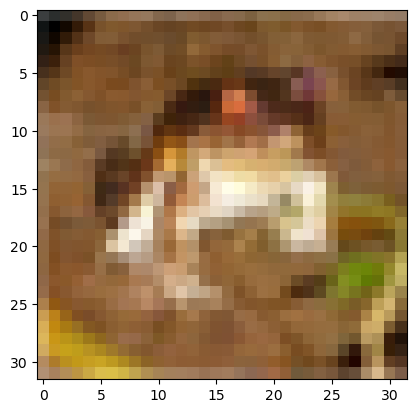

In [8]:

plt.imshow(trainset.data[0])
im,label = next(iter(trainloader))

In [9]:
def imshow(img):
    img = img / 2 + 0.5
    img = np.transpose(img.numpy(),(1,2,0))
    plt.imshow(img)

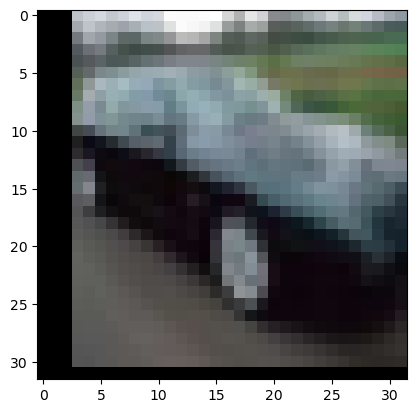

In [10]:
im[0].shape
imshow(im[0])

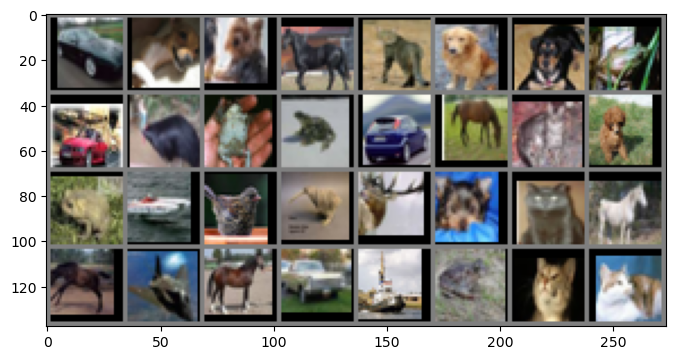

In [11]:
plt.figure(figsize=(8,12))
imshow(torchvision.utils.make_grid(im[:32]))

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## ResNet50 SGD

In [51]:
net = ResNet50().to(device)
if device == 'cuda':
    net = nn.DataParallel(net)
    torch.backends.cudnn.benchmark = True

In [52]:
summary(net,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]           4,096
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
           Conv2d-10          [-1, 256, 32, 32]          16,384
      BatchNorm2d-11          [-1, 256, 32, 32]             512
           Conv2d-12          [-1, 256, 32, 32]          16,384
      BatchNorm2d-13          [-1, 256, 32, 32]             512
       Bottleneck-14          [-1, 256,

In [14]:
epoch = 50

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5, min_lr=1e-5) 

In [15]:
Acc, Loss, Lr = train(net, trainloader, testloader, epoch, optimizer, criterion, scheduler)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch [  1/ 50] | Train Loss:1.834346 | Train Acc:34.04% | Test Loss:1.427608 | Test Acc:49.65% | Learning Rate:0.010000 | Time: 01:18
Epoch [  2/ 50] | Train Loss:1.293544 | Train Acc:53.11% | Test Loss:1.137674 | Test Acc:59.59% | Learning Rate:0.010000 | Time: 01:12
Epoch [  3/ 50] | Train Loss:0.969181 | Train Acc:65.81% | Test Loss:0.858734 | Test Acc:69.38% | Learning Rate:0.010000 | Time: 01:14
Epoch [  4/ 50] | Train Loss:0.764132 | Train Acc:73.30% | Test Loss:6.440874 | Test Acc:63.23% | Learning Rate:0.010000 | Time: 01:14
Epoch [  5/ 50] | Train Loss:0.650817 | Train Acc:77.53% | Test Loss:0.649956 | Test Acc:77.65% | Learning Rate:0.010000 | Time: 01:14
Epoch [  6/ 50] | Train Loss:0.556551 | Train Acc:80.66% | Test Loss:0.550713 | Test Acc:81.64% | Learning Rate:0.010000 | Time: 01:13
Epoch [  7/ 50] | Train Loss:0.496550 | Train Acc:83.04% | Test Loss:0.514386 | Test Acc:82.37% | Learning Rate:0.010000 | Time: 01:14
Epoch [  8/ 50] | Train Loss:0.456659 | Train Acc:84.23

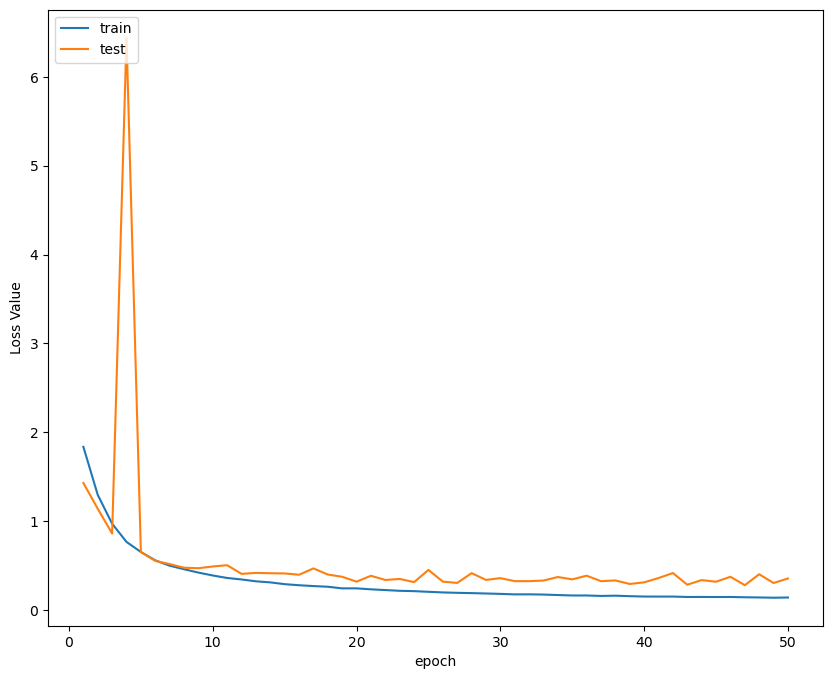

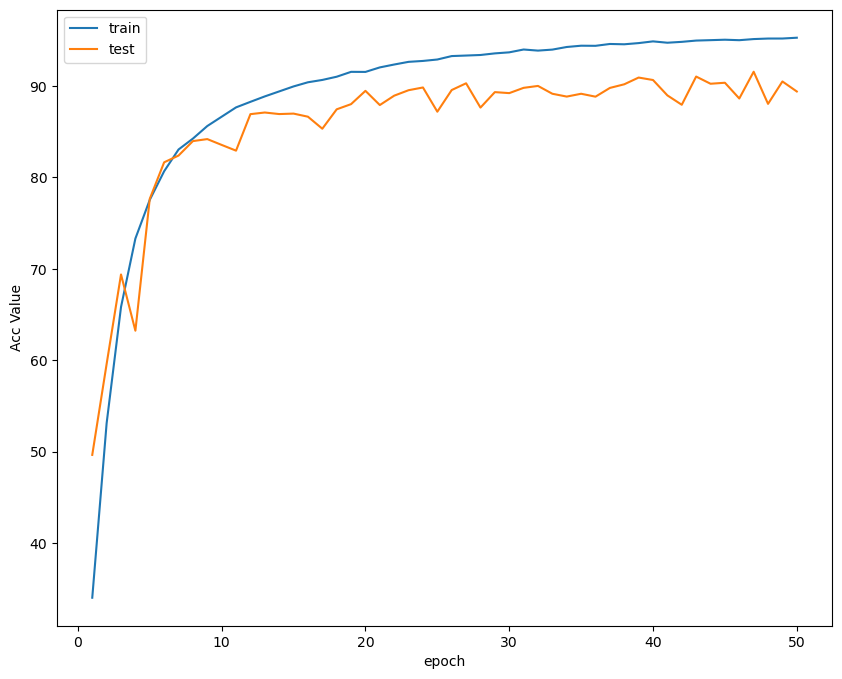

In [16]:
plot_history(epoch ,Acc, Loss)

In [17]:
correct = 0 # Define the number of correctly predicted images, initialized to 0
total = 0 # The total number of pictures participating in the test, also initialized to 0
torch.cuda.empty_cache()
net.eval()
with torch.no_grad():
    for data in testloader: # Loop through each batch
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        net.eval() # Convert the model to test mode
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images) # Enter the network for testing

        # outputs.data is a 4x10 tensor. The value and sequence number of the largest column of each row are formed into a one-dimensional tensor to return, the first is the value tensor, and the second is the sequence number tensor.
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0) # update the number of test images
        correct += (predicted == labels).sum() # update the number of correctly classified images

    print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 89.36 %


In [18]:
# Define 2 lists that store the number of correct tests in each class, initialized to 0
class_correct = list(0.for i in range(10))
class_total = list(0.for i in range(10))
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
    #4 group (batch_size) data, output in the same label, marked as 1, otherwise 0
        c = (predicted == labels).squeeze()
        for i in range(len(images)): # Because each batch has 4 images, a small loop of 4 is needed
            label = labels[i] # Accumulate each class separately
            class_correct[label] += c[i]
            class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 88.30 %
Accuracy of automobile : 95.90 %
Accuracy of  bird : 89.50 %
Accuracy of   cat : 81.10 %
Accuracy of  deer : 90.30 %
Accuracy of   dog : 86.30 %
Accuracy of  frog : 81.00 %
Accuracy of horse : 93.40 %
Accuracy of  ship : 93.60 %
Accuracy of truck : 94.20 %


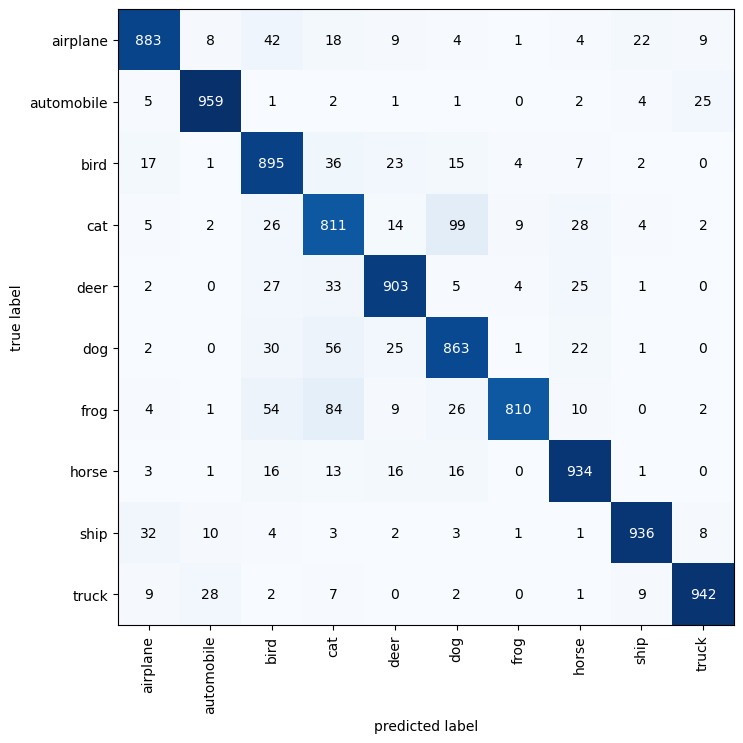

In [19]:
import numpy as np
from itertools import product

class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

mat = compute_confusion_matrix(model=net, data_loader=testloader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()

Accuracy Rate = 84.375%


<Figure size 2500x400 with 0 Axes>

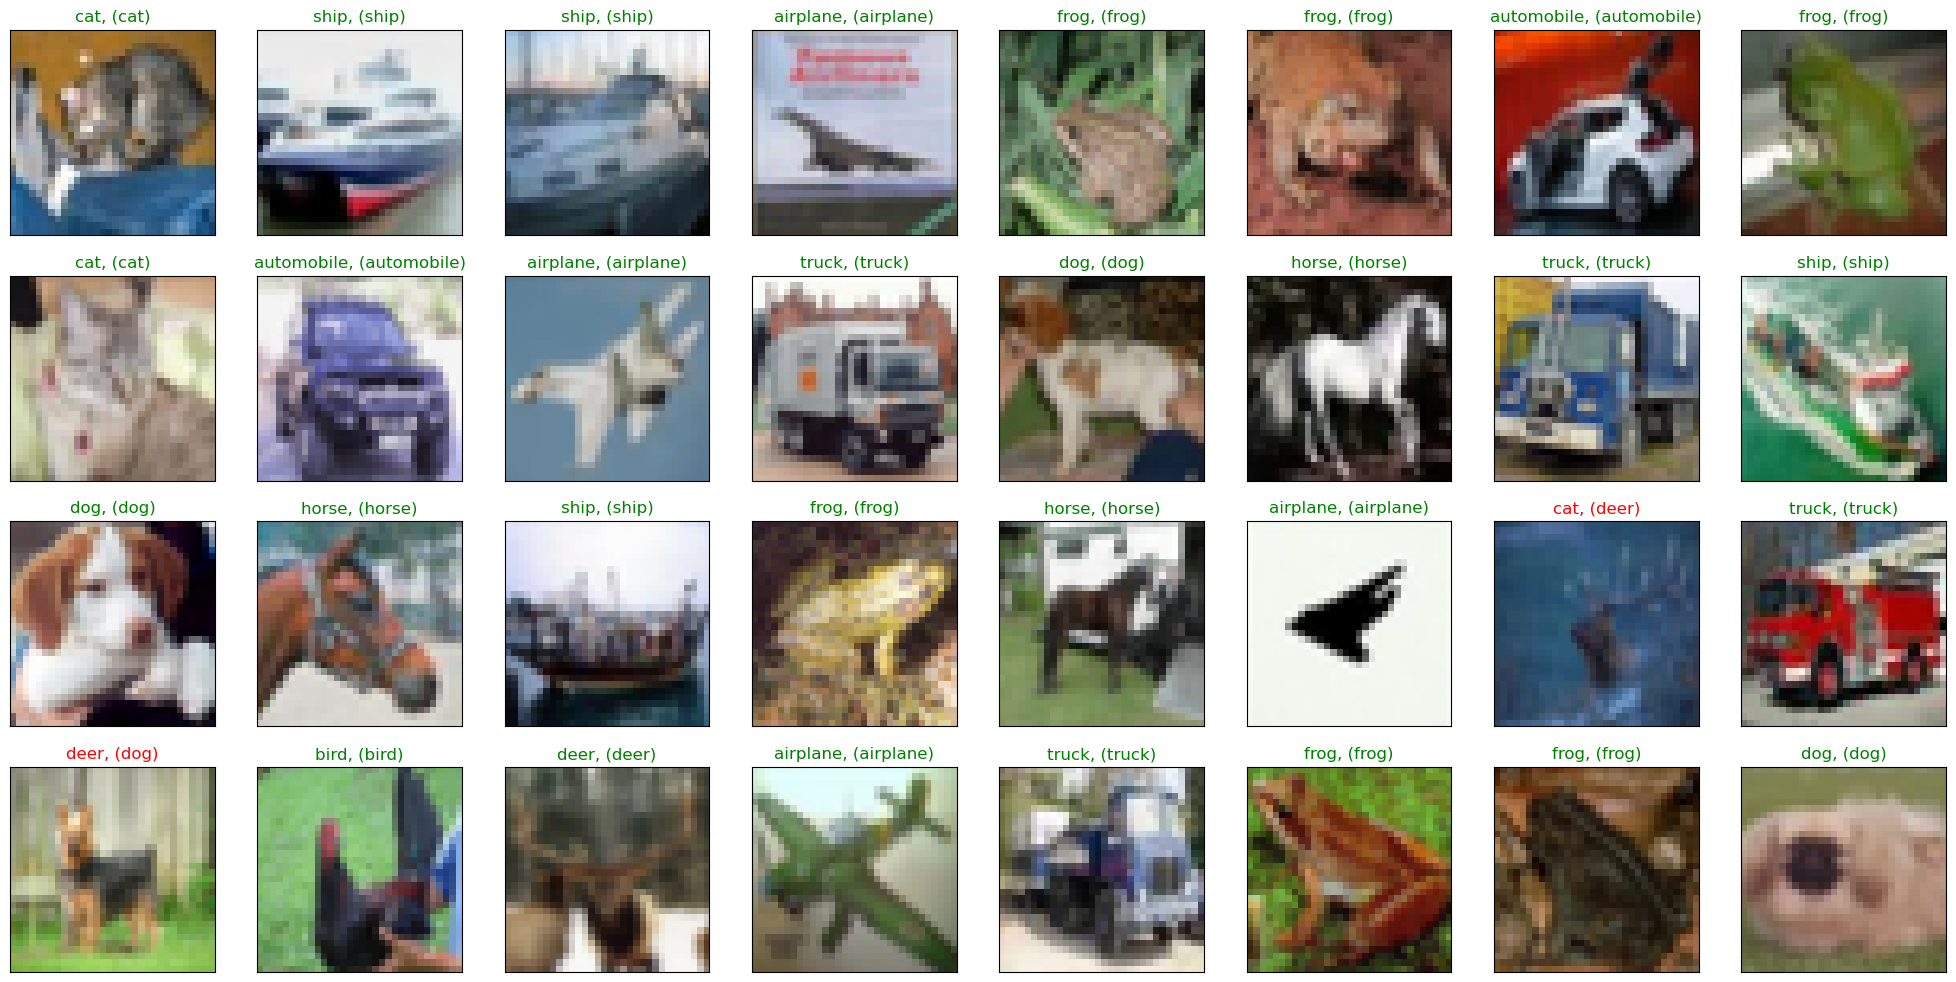

In [20]:
dataiter = iter(testloader)
images, labels = next(dataiter)
images_ = images
images_ = images_.to(device)
labels = labels.to(device)
val_output = net(images_)
_, val_preds = torch.max(val_output, 1)

fig = plt.figure(figsize=(25,4))

correct = torch.sum(val_preds == labels.data).item()

val_preds = val_preds.cpu()
labels = labels.cpu()

print("Accuracy Rate = {}%".format(correct/len(images) * 100))

fig = plt.figure(figsize=(25,25))
for idx in np.arange(32):    
    ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(
        "{}, ({})".format(classes[val_preds[idx].item()], classes[labels[idx].item()]), 
        color = ("green" if val_preds[idx].item()==labels[idx].item() else "red")
    )

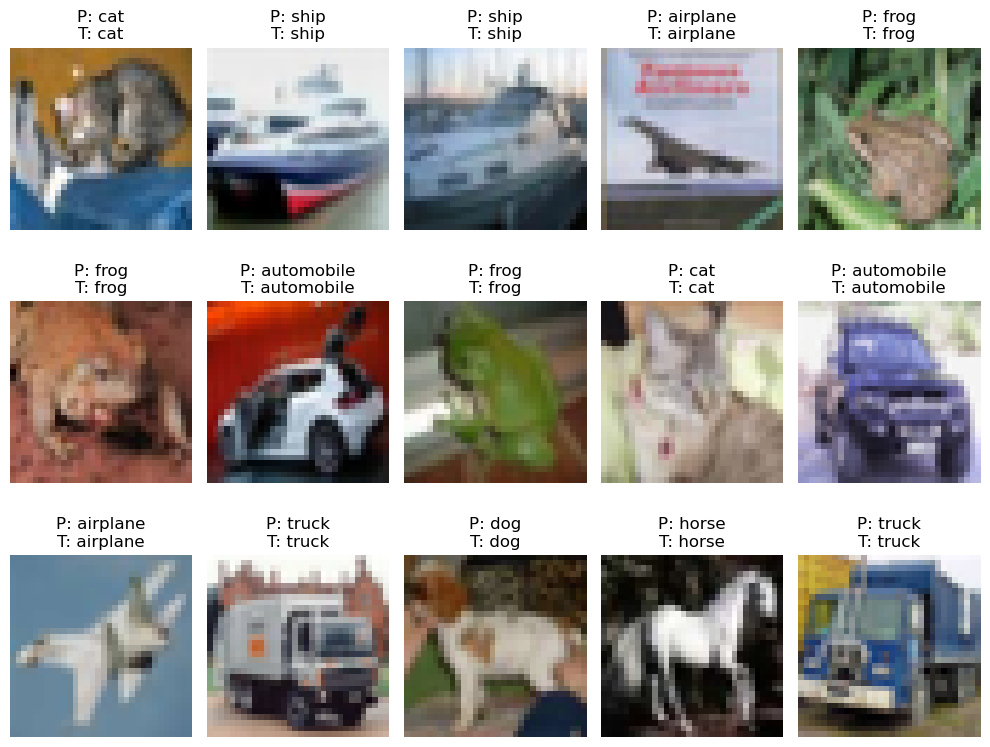

In [21]:
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

show_examples(model=net, data_loader=testloader, unnormalizer=unnormalizer, class_dict=class_dict)

## ResNet50 Adam

In [53]:
net = ResNet50().to(device)
if device == 'cuda':
    net = nn.DataParallel(net)
    torch.backends.cudnn.benchmark = True

In [54]:
summary(net,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]           4,096
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
           Conv2d-10          [-1, 256, 32, 32]          16,384
      BatchNorm2d-11          [-1, 256, 32, 32]             512
           Conv2d-12          [-1, 256, 32, 32]          16,384
      BatchNorm2d-13          [-1, 256, 32, 32]             512
       Bottleneck-14          [-1, 256,

In [23]:
epoch = 50

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [24]:
Acc, Loss, Lr = train(net, trainloader, testloader, epoch, optimizer, criterion)

Epoch [  1/ 50] | Train Loss:1.582545 | Train Acc:42.08% | Test Loss:1.167174 | Test Acc:57.54% | Learning Rate:0.001000 | Time: 01:15
Epoch [  2/ 50] | Train Loss:1.082982 | Train Acc:61.38% | Test Loss:1.065695 | Test Acc:63.68% | Learning Rate:0.001000 | Time: 01:15
Epoch [  3/ 50] | Train Loss:0.897277 | Train Acc:68.23% | Test Loss:0.888325 | Test Acc:68.88% | Learning Rate:0.001000 | Time: 01:14
Epoch [  4/ 50] | Train Loss:0.776499 | Train Acc:72.83% | Test Loss:0.794315 | Test Acc:72.59% | Learning Rate:0.001000 | Time: 01:15
Epoch [  5/ 50] | Train Loss:0.674916 | Train Acc:76.61% | Test Loss:0.702806 | Test Acc:76.20% | Learning Rate:0.001000 | Time: 01:15
Epoch [  6/ 50] | Train Loss:0.604892 | Train Acc:79.12% | Test Loss:0.585782 | Test Acc:80.60% | Learning Rate:0.001000 | Time: 01:15
Epoch [  7/ 50] | Train Loss:0.541674 | Train Acc:81.09% | Test Loss:0.532615 | Test Acc:81.56% | Learning Rate:0.001000 | Time: 01:15
Epoch [  8/ 50] | Train Loss:0.490256 | Train Acc:82.93

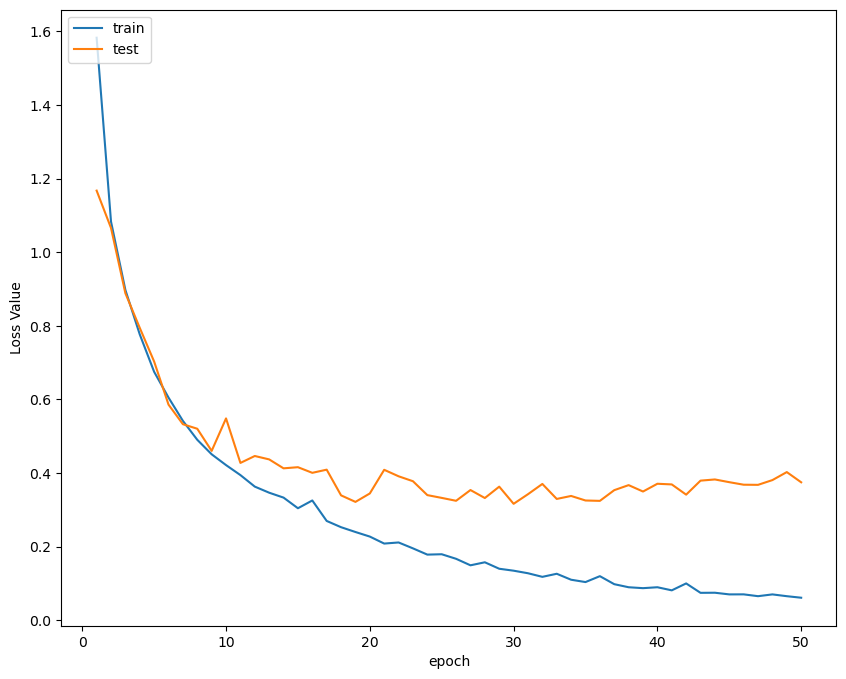

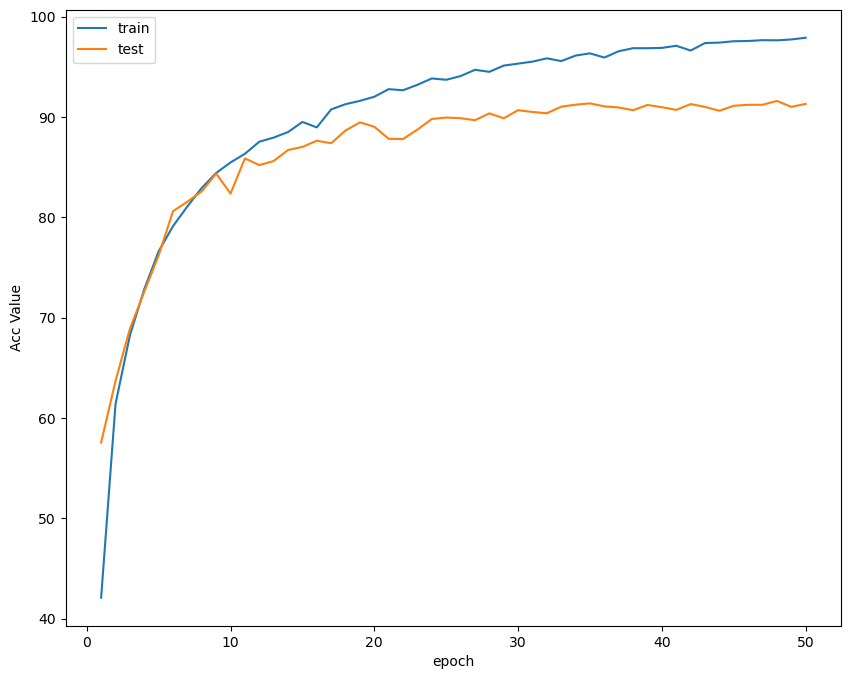

In [25]:
plot_history(epoch ,Acc, Loss)

In [26]:
correct = 0 # Define the number of correctly predicted images, initialized to 0
total = 0 # The total number of pictures participating in the test, also initialized to 0
torch.cuda.empty_cache()
net.eval()
with torch.no_grad():
    for data in testloader: # Loop through each batch
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        net.eval() # Convert the model to test mode
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images) # Enter the network for testing

        # outputs.data is a 4x10 tensor. The value and sequence number of the largest column of each row are formed into a one-dimensional tensor to return, the first is the value tensor, and the second is the sequence number tensor.
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0) # update the number of test images
        correct += (predicted == labels).sum() # update the number of correctly classified images

    print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 91.29 %


In [27]:
# Define 2 lists that store the number of correct tests in each class, initialized to 0
class_correct = list(0.for i in range(10))
class_total = list(0.for i in range(10))
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
    #4 group (batch_size) data, output in the same label, marked as 1, otherwise 0
        c = (predicted == labels).squeeze()
        for i in range(len(images)): # Because each batch has 4 images, a small loop of 4 is needed
            label = labels[i] # Accumulate each class separately
            class_correct[label] += c[i]
            class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 90.90 %
Accuracy of automobile : 94.30 %
Accuracy of  bird : 90.50 %
Accuracy of   cat : 82.20 %
Accuracy of  deer : 92.20 %
Accuracy of   dog : 80.80 %
Accuracy of  frog : 94.50 %
Accuracy of horse : 96.20 %
Accuracy of  ship : 96.60 %
Accuracy of truck : 94.70 %


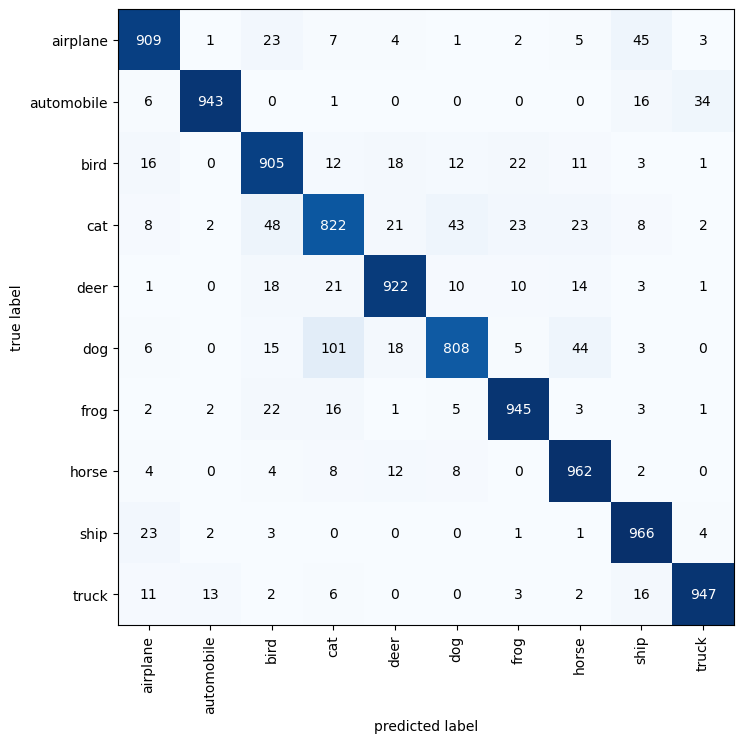

In [28]:
import numpy as np
from itertools import product

class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

mat = compute_confusion_matrix(model=net, data_loader=testloader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()

Accuracy Rate = 90.625%


<Figure size 2500x400 with 0 Axes>

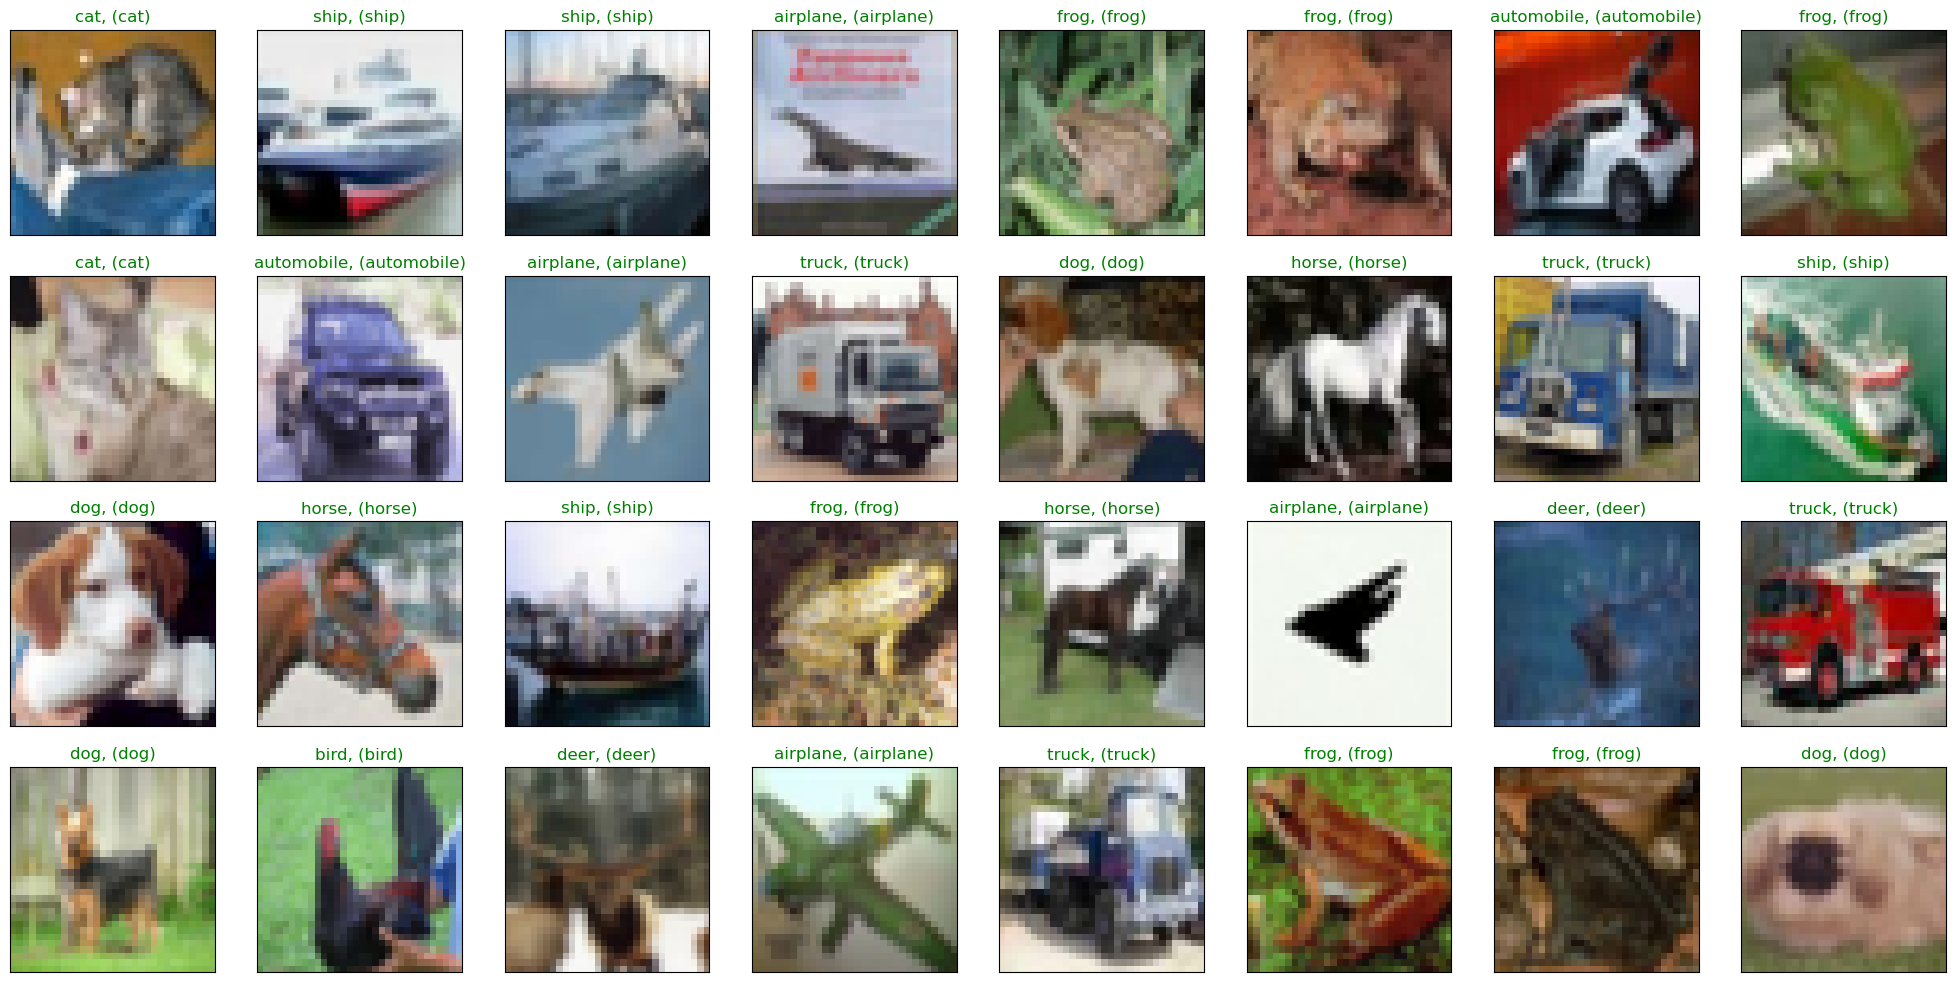

In [29]:
dataiter = iter(testloader)
images, labels = next(dataiter)
images_ = images
images_ = images_.to(device)
labels = labels.to(device)
val_output = net(images_)
_, val_preds = torch.max(val_output, 1)

fig = plt.figure(figsize=(25,4))

correct = torch.sum(val_preds == labels.data).item()

val_preds = val_preds.cpu()
labels = labels.cpu()

print("Accuracy Rate = {}%".format(correct/len(images) * 100))

fig = plt.figure(figsize=(25,25))
for idx in np.arange(32):    
    ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(
        "{}, ({})".format(classes[val_preds[idx].item()], classes[labels[idx].item()]), 
        color = ("green" if val_preds[idx].item()==labels[idx].item() else "red")
    )

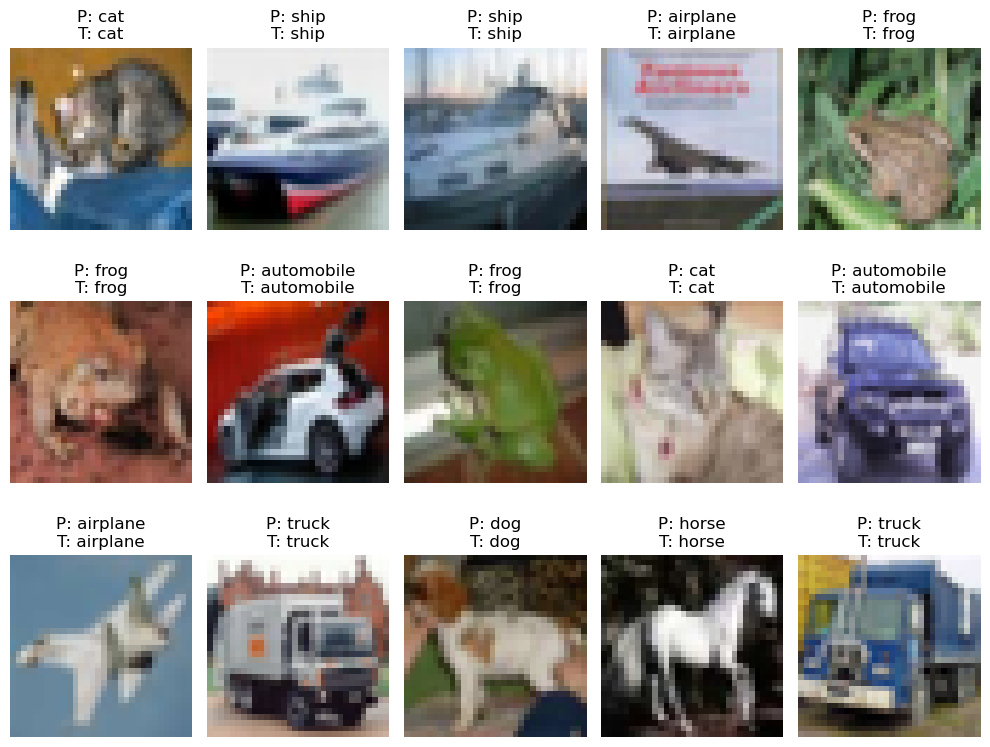

In [30]:
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

show_examples(model=net, data_loader=testloader, unnormalizer=unnormalizer, class_dict=class_dict)

## ResNet101 SGD

In [55]:
net = ResNet101().to(device)
if device == 'cuda':
    net = nn.DataParallel(net)
    torch.backends.cudnn.benchmark = True

In [56]:
summary(net,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]           4,096
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
           Conv2d-10          [-1, 256, 32, 32]          16,384
      BatchNorm2d-11          [-1, 256, 32, 32]             512
           Conv2d-12          [-1, 256, 32, 32]          16,384
      BatchNorm2d-13          [-1, 256, 32, 32]             512
       Bottleneck-14          [-1, 256,

In [32]:
epoch = 50

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5, min_lr=1e-5) 

In [33]:
Acc, Loss, Lr = train(net, trainloader, testloader, epoch, optimizer, criterion, scheduler)

Epoch [  1/ 50] | Train Loss:1.829571 | Train Acc:34.55% | Test Loss:1.706943 | Test Acc:45.62% | Learning Rate:0.010000 | Time: 01:37
Epoch [  2/ 50] | Train Loss:1.333058 | Train Acc:51.29% | Test Loss:1.679844 | Test Acc:52.08% | Learning Rate:0.010000 | Time: 01:36
Epoch [  3/ 50] | Train Loss:1.108458 | Train Acc:60.60% | Test Loss:1.086238 | Test Acc:64.24% | Learning Rate:0.010000 | Time: 01:37
Epoch [  4/ 50] | Train Loss:0.875169 | Train Acc:69.26% | Test Loss:1.012841 | Test Acc:71.00% | Learning Rate:0.010000 | Time: 01:37
Epoch [  5/ 50] | Train Loss:0.718310 | Train Acc:75.01% | Test Loss:0.836816 | Test Acc:72.99% | Learning Rate:0.010000 | Time: 01:36
Epoch [  6/ 50] | Train Loss:0.611022 | Train Acc:79.05% | Test Loss:0.645066 | Test Acc:79.54% | Learning Rate:0.010000 | Time: 01:37
Epoch [  7/ 50] | Train Loss:0.546675 | Train Acc:81.05% | Test Loss:0.565459 | Test Acc:80.47% | Learning Rate:0.010000 | Time: 01:37
Epoch [  8/ 50] | Train Loss:0.491112 | Train Acc:83.12

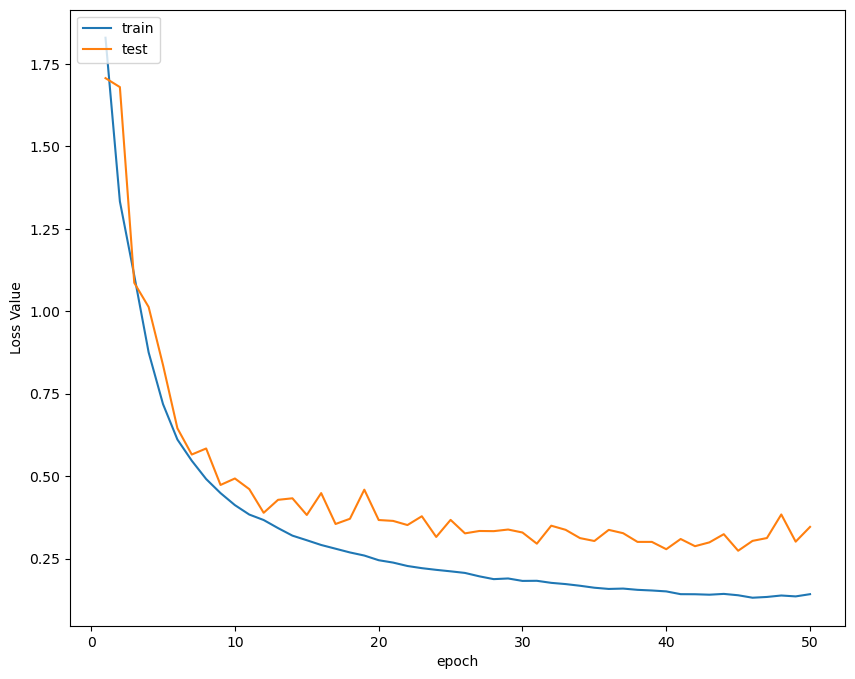

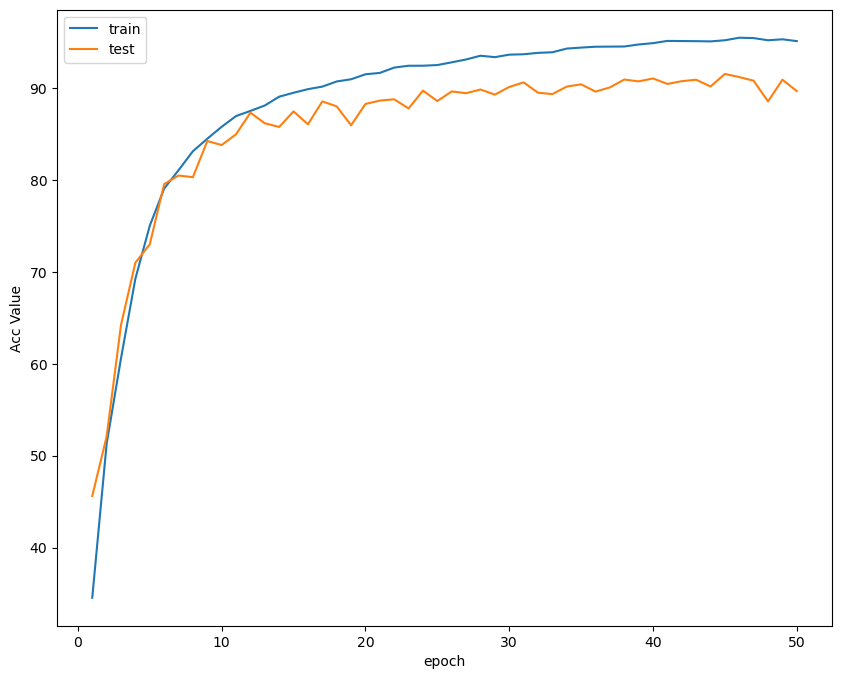

In [34]:
plot_history(epoch ,Acc, Loss)

In [35]:
correct = 0 # Define the number of correctly predicted images, initialized to 0
total = 0 # The total number of pictures participating in the test, also initialized to 0
torch.cuda.empty_cache()
net.eval()
with torch.no_grad():
    for data in testloader: # Loop through each batch
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        net.eval() # Convert the model to test mode
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images) # Enter the network for testing

        # outputs.data is a 4x10 tensor. The value and sequence number of the largest column of each row are formed into a one-dimensional tensor to return, the first is the value tensor, and the second is the sequence number tensor.
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0) # update the number of test images
        correct += (predicted == labels).sum() # update the number of correctly classified images

    print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 89.67 %


In [36]:
# Define 2 lists that store the number of correct tests in each class, initialized to 0
class_correct = list(0.for i in range(10))
class_total = list(0.for i in range(10))
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
    #4 group (batch_size) data, output in the same label, marked as 1, otherwise 0
        c = (predicted == labels).squeeze()
        for i in range(len(images)): # Because each batch has 4 images, a small loop of 4 is needed
            label = labels[i] # Accumulate each class separately
            class_correct[label] += c[i]
            class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 90.70 %
Accuracy of automobile : 96.50 %
Accuracy of  bird : 92.30 %
Accuracy of   cat : 81.20 %
Accuracy of  deer : 97.30 %
Accuracy of   dog : 76.30 %
Accuracy of  frog : 86.20 %
Accuracy of horse : 90.50 %
Accuracy of  ship : 91.60 %
Accuracy of truck : 94.10 %


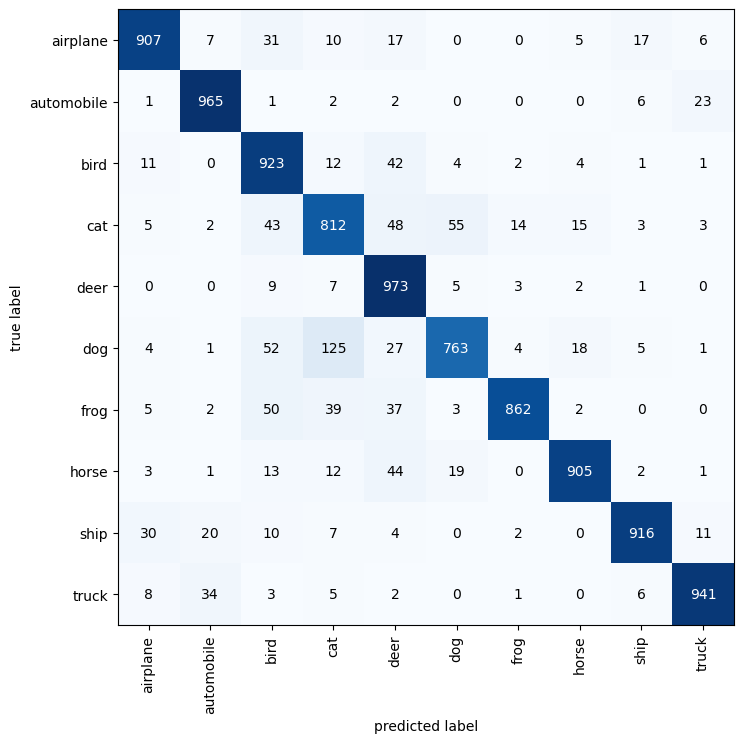

In [37]:
import numpy as np
from itertools import product

class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

mat = compute_confusion_matrix(model=net, data_loader=testloader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()

Accuracy Rate = 90.625%


<Figure size 2500x400 with 0 Axes>

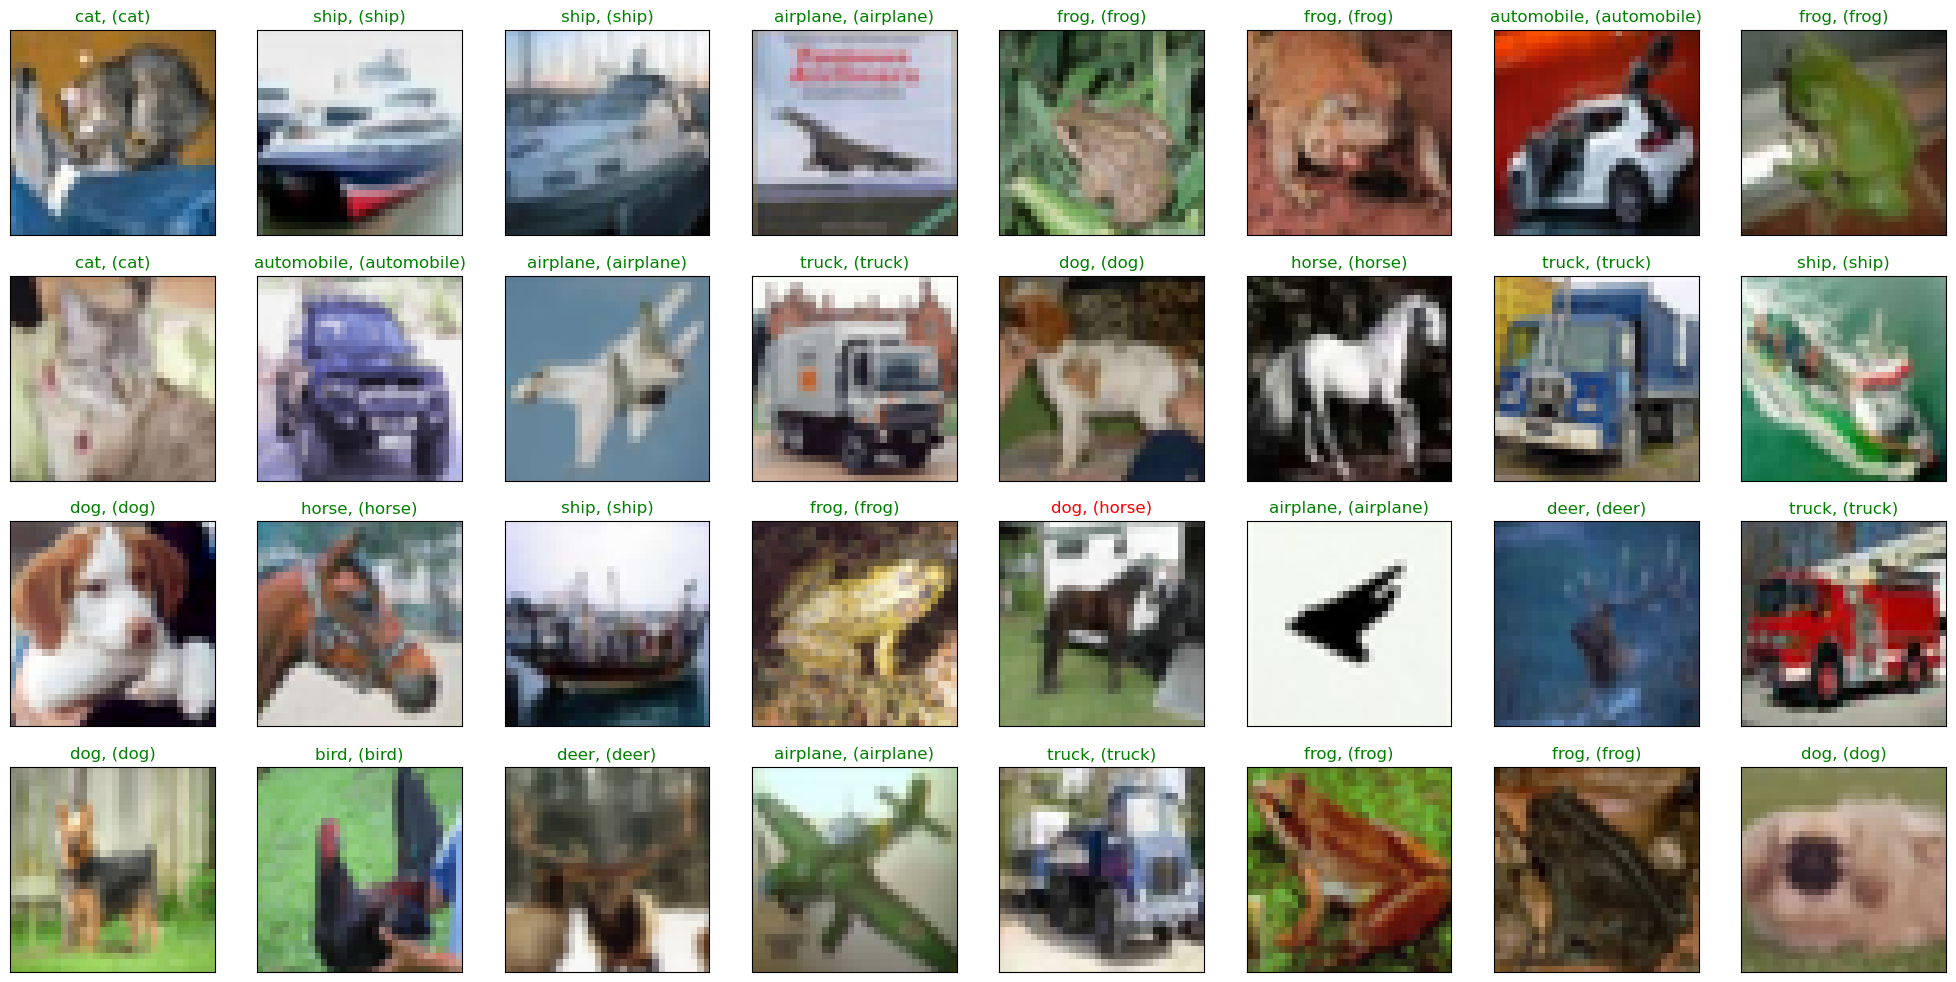

In [38]:
dataiter = iter(testloader)
images, labels = next(dataiter)
images_ = images
images_ = images_.to(device)
labels = labels.to(device)
val_output = net(images_)
_, val_preds = torch.max(val_output, 1)

fig = plt.figure(figsize=(25,4))

correct = torch.sum(val_preds == labels.data).item()

val_preds = val_preds.cpu()
labels = labels.cpu()

print("Accuracy Rate = {}%".format(correct/len(images) * 100))

fig = plt.figure(figsize=(25,25))
for idx in np.arange(32):    
    ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(
        "{}, ({})".format(classes[val_preds[idx].item()], classes[labels[idx].item()]), 
        color = ("green" if val_preds[idx].item()==labels[idx].item() else "red")
    )

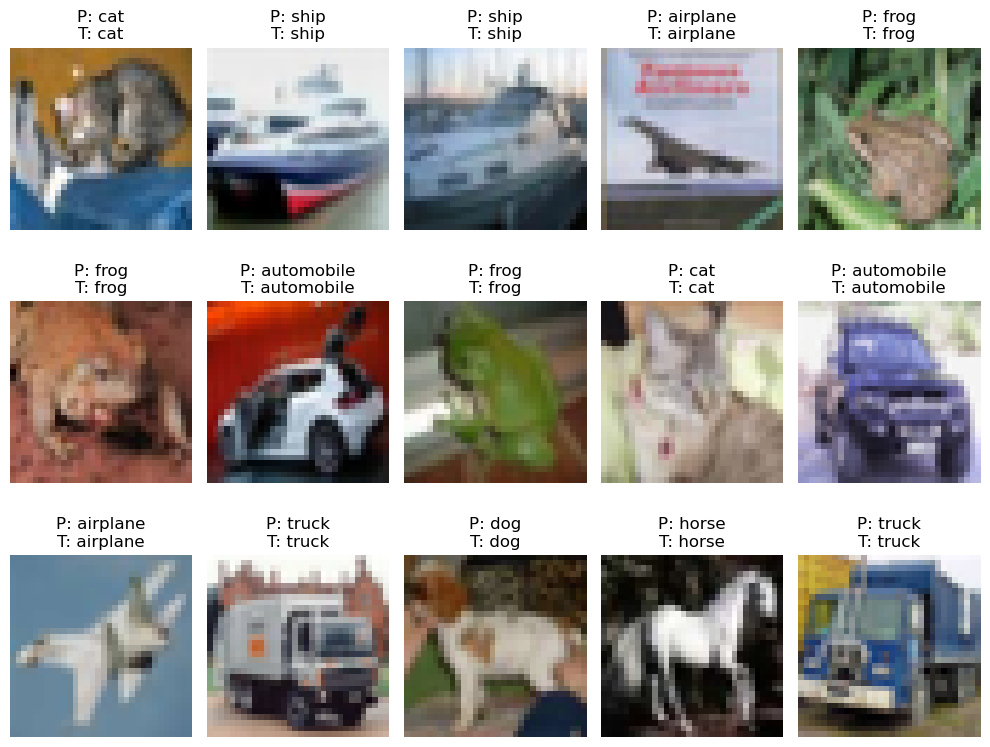

In [39]:
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

show_examples(model=net, data_loader=testloader, unnormalizer=unnormalizer, class_dict=class_dict)

## ResNet101 Adam

In [57]:
net = ResNet101().to(device)
if device == 'cuda':
    net = nn.DataParallel(net)
    torch.backends.cudnn.benchmark = True

In [58]:
summary(net,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]           4,096
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
           Conv2d-10          [-1, 256, 32, 32]          16,384
      BatchNorm2d-11          [-1, 256, 32, 32]             512
           Conv2d-12          [-1, 256, 32, 32]          16,384
      BatchNorm2d-13          [-1, 256, 32, 32]             512
       Bottleneck-14          [-1, 256,

In [41]:
epoch = 50

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [42]:
Acc, Loss, Lr = train(net, trainloader, testloader, epoch, optimizer, criterion)

Epoch [  1/ 50] | Train Loss:1.770114 | Train Acc:34.31% | Test Loss:1.424162 | Test Acc:46.37% | Learning Rate:0.001000 | Time: 01:37
Epoch [  2/ 50] | Train Loss:1.258011 | Train Acc:54.29% | Test Loss:1.114211 | Test Acc:60.17% | Learning Rate:0.001000 | Time: 01:36
Epoch [  3/ 50] | Train Loss:1.030362 | Train Acc:63.02% | Test Loss:1.443935 | Test Acc:54.83% | Learning Rate:0.001000 | Time: 01:36
Epoch [  4/ 50] | Train Loss:0.882622 | Train Acc:68.88% | Test Loss:0.856601 | Test Acc:70.97% | Learning Rate:0.001000 | Time: 01:38
Epoch [  5/ 50] | Train Loss:0.798433 | Train Acc:72.18% | Test Loss:0.702180 | Test Acc:75.48% | Learning Rate:0.001000 | Time: 01:41
Epoch [  6/ 50] | Train Loss:0.646167 | Train Acc:77.67% | Test Loss:0.660966 | Test Acc:77.55% | Learning Rate:0.001000 | Time: 01:40
Epoch [  7/ 50] | Train Loss:0.681266 | Train Acc:76.90% | Test Loss:0.757846 | Test Acc:74.33% | Learning Rate:0.001000 | Time: 01:40
Epoch [  8/ 50] | Train Loss:0.651585 | Train Acc:77.70

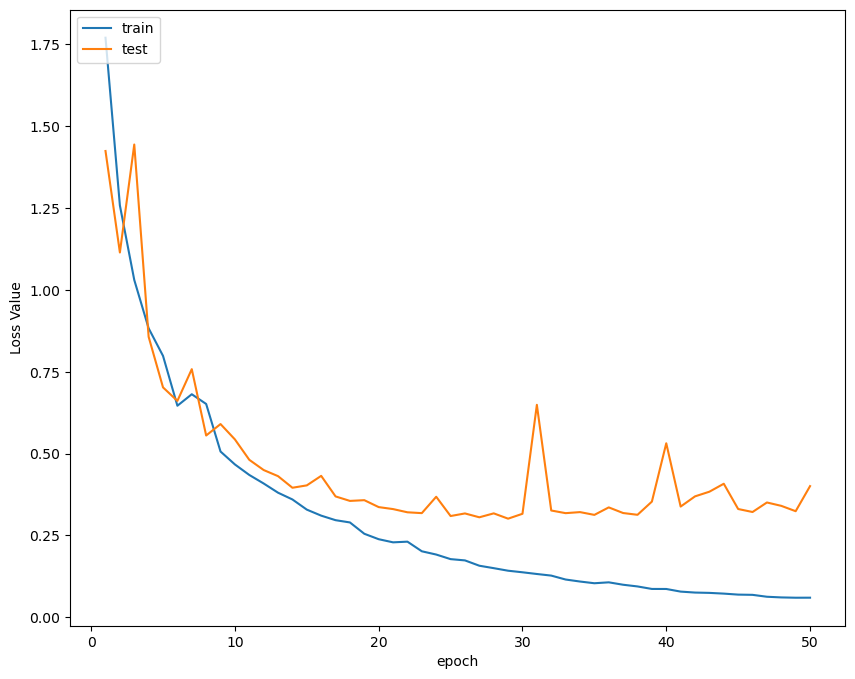

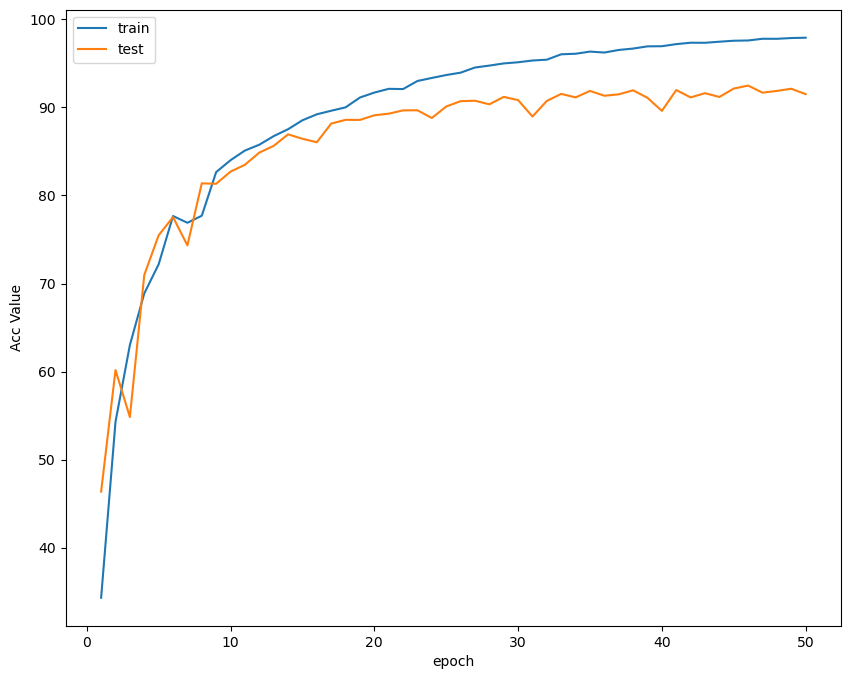

In [43]:
plot_history(epoch ,Acc, Loss)

In [44]:
correct = 0 # Define the number of correctly predicted images, initialized to 0
total = 0 # The total number of pictures participating in the test, also initialized to 0
# testloader = torch.utils.data.DataLoader(testset, batch_size=32,shuffle=True, num_workers=2)
torch.cuda.empty_cache()
net.eval()
with torch.no_grad():
    for data in testloader: # Loop through each batch
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        net.eval() # Convert the model to test mode
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images) # Enter the network for testing

        # outputs.data is a 4x10 tensor. The value and sequence number of the largest column of each row are formed into a one-dimensional tensor to return, the first is the value tensor, and the second is the sequence number tensor.
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0) # update the number of test images
        correct += (predicted == labels).sum() # update the number of correctly classified images

    print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 91.50 %


In [45]:
# Define 2 lists that store the number of correct tests in each class, initialized to 0
class_correct = list(0.for i in range(10))
class_total = list(0.for i in range(10))
# testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True, num_workers=2)
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
    #4 group (batch_size) data, output in the same label, marked as 1, otherwise 0
        c = (predicted == labels).squeeze()
        for i in range(len(images)): # Because each batch has 4 images, a small loop of 4 is needed
            label = labels[i] # Accumulate each class separately
            class_correct[label] += c[i]
            class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 93.60 %
Accuracy of automobile : 94.10 %
Accuracy of  bird : 87.30 %
Accuracy of   cat : 79.70 %
Accuracy of  deer : 92.90 %
Accuracy of   dog : 87.90 %
Accuracy of  frog : 97.30 %
Accuracy of horse : 91.90 %
Accuracy of  ship : 97.50 %
Accuracy of truck : 92.80 %


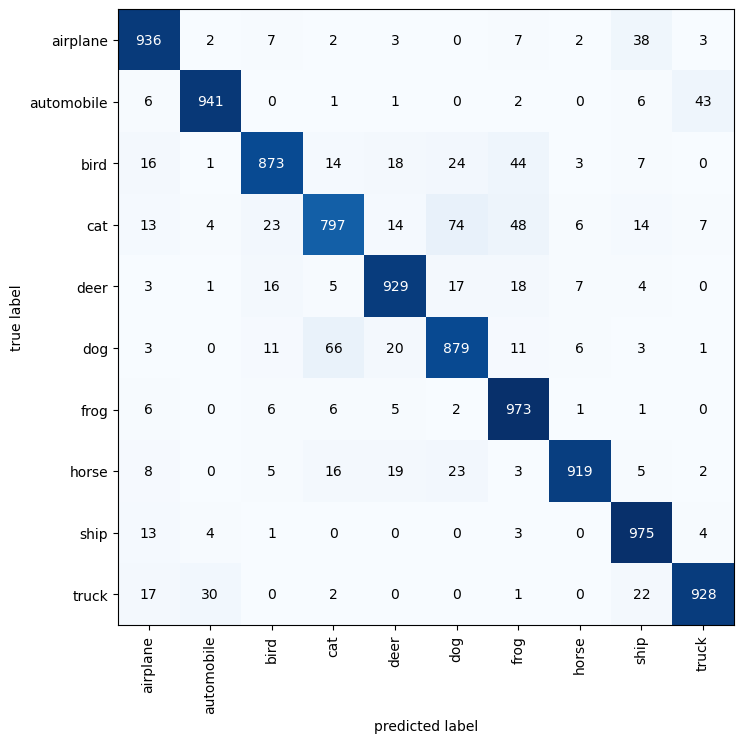

In [46]:
import numpy as np
from itertools import product

class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

mat = compute_confusion_matrix(model=net, data_loader=testloader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()

Accuracy Rate = 92.1875%


<Figure size 2500x400 with 0 Axes>

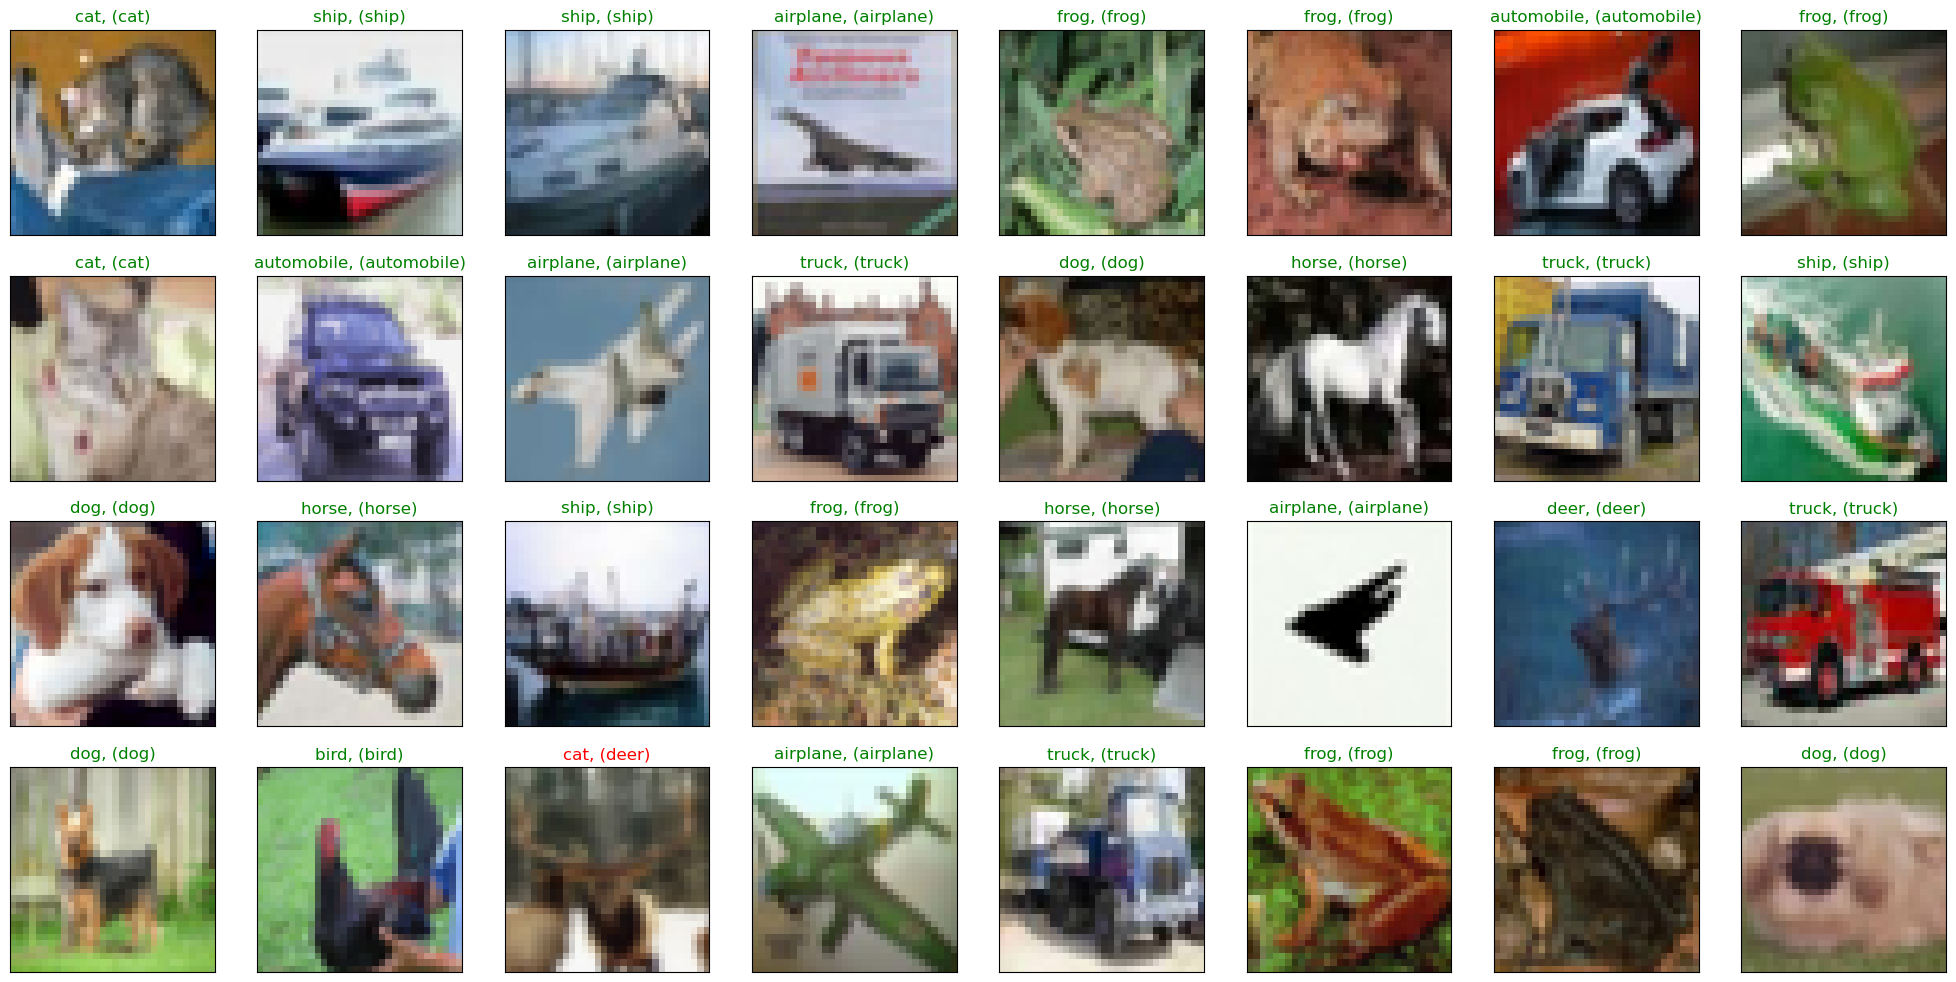

In [47]:
dataiter = iter(testloader)
images, labels = next(dataiter)
images_ = images
images_ = images_.to(device)
labels = labels.to(device)
val_output = net(images_)
_, val_preds = torch.max(val_output, 1)

fig = plt.figure(figsize=(25,4))

correct = torch.sum(val_preds == labels.data).item()

val_preds = val_preds.cpu()
labels = labels.cpu()

print("Accuracy Rate = {}%".format(correct/len(images) * 100))

fig = plt.figure(figsize=(25,25))
for idx in np.arange(32):    
    ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(
        "{}, ({})".format(classes[val_preds[idx].item()], classes[labels[idx].item()]), 
        color = ("green" if val_preds[idx].item()==labels[idx].item() else "red")
    )

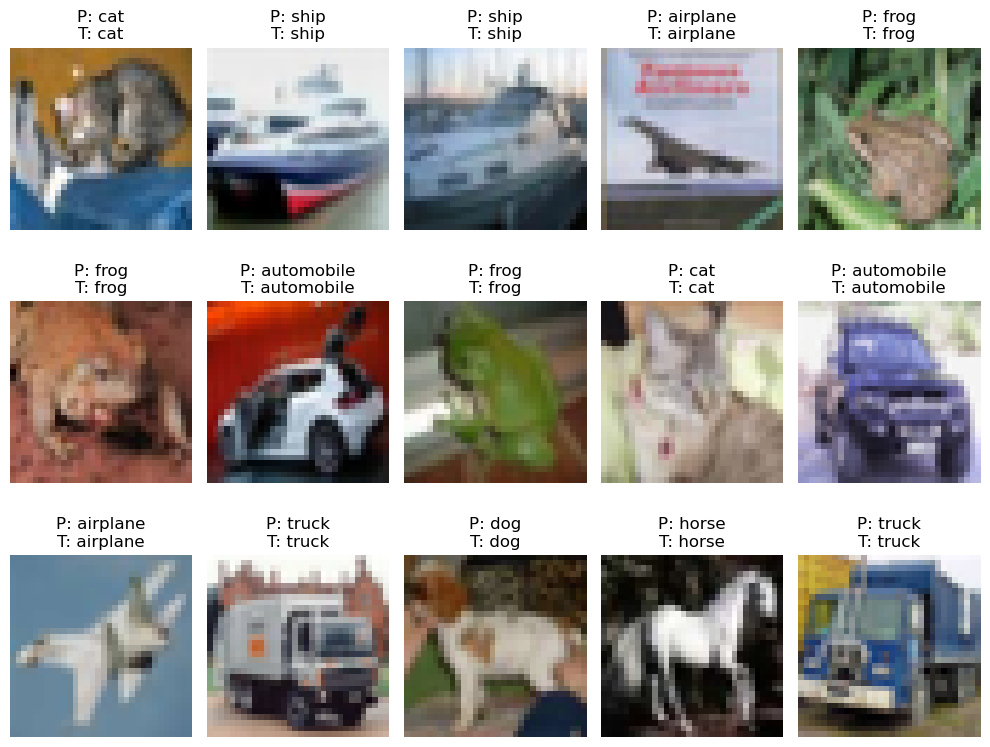

In [48]:
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

show_examples(model=net, data_loader=testloader, unnormalizer=unnormalizer, class_dict=class_dict)